In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output, display, update_display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}')

max_memory = torch.cuda.get_device_properties(0).total_memory  # Общий объем памяти на GPU
used_memory = torch.cuda.memory_allocated(0)  # Используемая память на GPU
available_memory = max_memory - used_memory

print(f"Общая память GPU: {max_memory / 1e9:.2f} ГБ")
print(f"Свободная память GPU: {available_memory / 1e9:.2f} ГБ")

Using cuda
Общая память GPU: 4.29 ГБ
Свободная память GPU: 4.29 ГБ


In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images_A = sorted(os.listdir(os.path.join(root_dir, 'trainA')))
        self.images_B = sorted(os.listdir(os.path.join(root_dir, 'trainB')))

    def __len__(self):
        return len(self.images_A)

    def __getitem__(self, idx):
        imgA_path = os.path.join(self.root_dir, 'trainA', self.images_A[idx])
        imgB_path = os.path.join(self.root_dir, 'trainB', self.images_B[idx])
        
        imgA = Image.open(imgA_path).convert("RGB")
        imgB = Image.open(imgB_path).convert("RGB")

        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)

        return imgA, imgB

def visualize_results(input_image, generated_image, target_image):
    # Обратная нормализация
    unnormalize = T.Normalize((-1, -1, -1), (2, 2, 2))
    input_image = unnormalize(input_image)
    generated_image = unnormalize(generated_image)
    target_image = unnormalize(target_image)

    # Преобразование из тензоров в изображения
    input_image = input_image.permute(1, 2, 0).cpu().numpy()
    generated_image = generated_image.permute(1, 2, 0).detach().cpu().numpy()
    target_image = target_image.permute(1, 2, 0).cpu().numpy()

    # Отображение
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title("Radar Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(generated_image)
    plt.title("Generated Optical Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(target_image)
    plt.title("Target Optical Image")
    plt.axis("off")

    plt.show()

def save_best_model(epoch, model, optimizer, loss, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filepath)
    print(f"Best model saved at epoch {epoch} with loss {loss:.4f}")

def load_checkpoint(filepath, model, optimizer=None):
    checkpoint = torch.load(filepath)  # Загрузка данных чекпоинта
    model.load_state_dict(checkpoint['model_state_dict'])  # Восстановление весов модели
    if optimizer:  # Если требуется восстановить оптимизатор
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']  # Последняя сохранённая эпоха
    loss = checkpoint['loss']  # Последняя сохранённая функция потерь
    print(f"Модель загружена: epoch {epoch}, loss {loss}")
    return epoch

def save_loss_history(train_loss_history, test_loss_history, filepath):
    np.savez(filepath, train_loss=train_loss_history, test_loss=test_loss_history)
    print(f"Loss history saved to {filepath}")

def load_loss_history(filepath):
    try:
        data = np.load(filepath)
        train_loss = data['train_loss'].tolist()  # Преобразуем обратно в список
        test_loss = data['test_loss'].tolist()  # Преобразуем обратно в список
        print(f"Loss history loaded from {filepath}")
        return train_loss, test_loss
    except FileNotFoundError:
        print(f"Loss history ({filepath}) не найдена, начинаем сначала.")
        return [], []

In [3]:
transform = T.Compose([
    T.Resize((256, 256)),  # Изменение размера
    T.ToTensor(),          # Преобразование в тензор
    T.Normalize((0.5,), (0.5,))  # Нормализация
])

train_dataset = CustomDataset(root_dir='dataset', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = CustomDataset(root_dir='dataset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [4]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def down_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2)
            )

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
            )

        self.down1 = down_block(3, 64)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)

        self.middle = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up4 = up_block(1024 + 512, 512)
        self.up3 = up_block(512 + 256, 256)
        self.up2 = up_block(256 + 128, 128)
        self.up1 = up_block(128 + 64, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)  # [N, 64, H/2, W/2]
        d2 = self.down2(d1)  # [N, 128, H/4, W/4]
        d3 = self.down3(d2)  # [N, 256, H/8, W/8]
        d4 = self.down4(d3)  # [N, 512, H/16, W/16]

        m = self.middle(d4)  # [N, 1024, H/16, W/16]
        u4 = self.up4(torch.cat([m, d4], dim=1))  # [N, 512, H/8, W/8]
        u3 = self.up3(torch.cat([u4, d3], dim=1))  # [N, 256, H/4, W/4]
        u2 = self.up2(torch.cat([u3, d2], dim=1))  # [N, 128, H/2, W/2]
        u1 = self.up1(torch.cat([u2, d1], dim=1))  # [N, 64, H, W]
        return self.final(u1)  # [N, 3, H, W]


In [5]:
import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        weights = VGG16_Weights.IMAGENET1K_V1  # Предобученные веса VGG16 на ImageNet
        vgg = vgg16(weights=weights).features[:8]  # Берём первые 16 слоёв
        for param in vgg.parameters():
            param.requires_grad = False  # Замораживаем веса
        self.vgg = vgg.eval()  # Устанавливаем режим оценки

    def forward(self, input, target):
        input_features = self.vgg(input)
        target_features = self.vgg(target)
        return torch.nn.functional.mse_loss(input_features, target_features)


from torchmetrics.functional import structural_similarity_index_measure as ssim

def ssim_loss(input, target):
    return 1 - ssim(input, target)

def total_variation_loss(img):
    return torch.sum(torch.abs(img[:, :, :-1] - img[:, :, 1:])) + \
           torch.sum(torch.abs(img[:, :-1, :] - img[:, 1:, :]))

class CombinedLoss(nn.Module):
    def __init__(self, perceptual_weight=0.1, ssim_weight=0.1, mse_weight=1.0, tv_weight=0.01):
        super(CombinedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.perceptual_loss = PerceptualLoss()
        self.ssim_weight = ssim_weight
        self.tv_weight = tv_weight
        self.perceptual_weight = perceptual_weight
        self.mse_weight = mse_weight

    def forward(self, output, target):
        mse = self.mse_loss(output, target)
        perceptual = self.perceptual_loss(output, target)
        ssim_l = ssim_loss(output, target)
        tv = total_variation_loss(output)

        return self.mse_weight * mse + \
               self.perceptual_weight * perceptual + \
               self.ssim_weight * ssim_l + \
               self.tv_weight * tv


Пояснение:
- **perceptual_weight=0.2:**
    Радиолокационные изображения сложные, и визуальные текстуры имеют значение, но не настолько критичны, как структурные элементы.

- **ssim_weight=0.5:**
    Увеличенный вес SSIM позволит модели сосредоточиться на сохранении структурных характеристик, что важно для интерпретируемости результатов.

- **mse_weight=1.0:**
    Оставляем базовым, чтобы пиксельная ошибка оставалась основным направляющим компонентом.

- **tv_weight=0.01:**
    Малый вес TV Loss помогает устранить шум, но не доминирует над другими компонентами.

C:\Users\tiruu\AppData\Local\Temp\ipykernel_1764\4138479991.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)  # Загрузка данных чекпоин

Модель загружена: epoch 1, loss 159.26233910676092
Loss history loaded from loss_history.npz


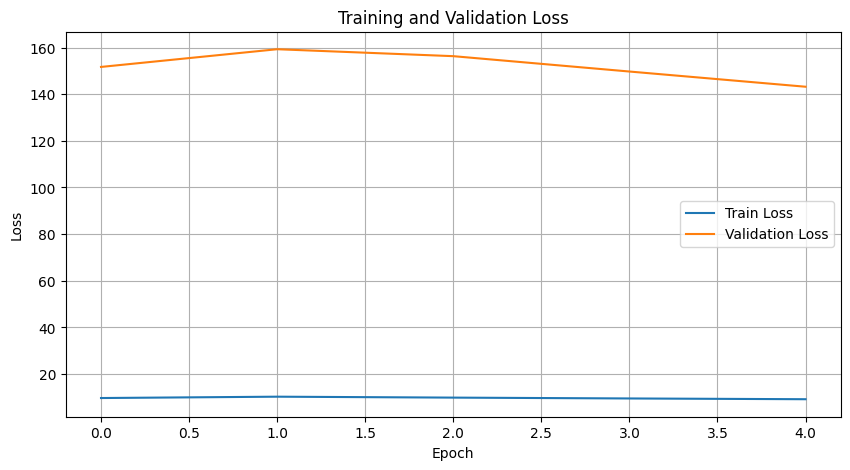

  1%|1         | 1/100 [00:00<?, ?epoch/s]

Loss history saved to loss_history.npz
Best model saved at epoch 2 with loss 156.2849
Loss history saved to loss_history.npz
Best model saved at epoch 3 with loss 149.7010
Loss history saved to loss_history.npz
Best model saved at epoch 4 with loss 143.1812


In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.9))
# criterion = CombinedLoss(
#     perceptual_weight=0.2,  # Умеренный вес для перцептивной потери
#     ssim_weight=0.5,       # Усиленный вес для сохранения структуры
#     mse_weight=1.0,        # Базовый вес для пиксельной ошибки
#     tv_weight=0.01         # Малый вес для сглаживания
# ).to(device)
criterion = nn.MSELoss()

checkpoint_path = os.path.join("checkpoints", "best_model.pth")
start_epoch = 0

if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer)
else:
    print("Модель создана заново.")

# Early stopping параметры
patience = 10
best_test_loss = float('inf')
wait = 0

# Логирование
train_loss_history, test_loss_history = load_loss_history("loss_history.npz")
# Инициализация графика (вне цикла)
plt.ion()
fig, ax = plt.subplots(figsize=(10, 5))
train_line, = ax.plot(range(len(train_loss_history)), train_loss_history, label="Train Loss")
test_line, = ax.plot(range(len(test_loss_history)), test_loss_history, label="Validation Loss")
ax.relim()  # Пересчитываем границы
ax.autoscale_view(scalex=True, scaley=True)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.legend()
ax.grid(True)

# Отображение графика в отдельной ячейке
display(fig, display_id="loss_graph")

from torch.amp import autocast, GradScaler  # Импорт необходимых инструментов

# Инициализация масштабировщика градиентов
# scaler = GradScaler()

# Количество эпох
total_epochs = 100
with tqdm(total=total_epochs, unit='epoch', initial=start_epoch) as pbar:
    for epoch in range(start_epoch , total_epochs):
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaN detected in gradients for {name}")

        if epoch == start_epoch:  # Пропускаем обработку загруженной эпохи
            continue

        model.train()
        train_loss = 0
        for imgA, imgB in train_loader:
            imgA, imgB = imgA.to(device), imgB.to(device)

            optimizer.zero_grad()
            outputs = model(imgA)
            loss = criterion(outputs, imgB)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss_history.append(train_loss)

        # Оценка на тестовом наборе
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for imgA, imgB in test_loader:
                imgA, imgB = imgA.to(device), imgB.to(device)
                outputs = model(imgA)
                loss = criterion(outputs, imgB)
                    
                test_loss += loss.item()
        test_loss_history.append(test_loss)

        # Сохранение истории потерь после каждой эпохи
        save_loss_history(train_loss_history, test_loss_history, "loss_history.npz")

        # Ранняя остановка
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            wait = 0
            save_best_model(epoch, model, optimizer, test_loss, checkpoint_path)  # Сохранение только лучшей модели
        else:
            wait += 1
            if wait >= patience:
                pbar.set_description(f"Early stopping triggered at epoch {epoch}")  # Обновляем описание tqdm
                pbar.update(1)
                break

        # Обновление tqdm
        pbar.set_description(f"Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}")
        pbar.update(1)

        # График потерь
        train_line.set_data(range(len(train_loss_history)), train_loss_history)
        test_line.set_data(range(len(test_loss_history)), test_loss_history)
        ax.relim()  # Пересчитываем границы
        ax.autoscale_view(scalex=True, scaley=True)  # Автоматически обновляем масштаб
        update_display(fig, display_id="loss_graph")  # Обновляем график в ячейке

# Загрузка лучшей модели
model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
print("Загружена лучшая модель!")